In [1]:
%matplotlib inline
import matplotlib as mpl
plt = mpl.pyplot
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
import numpy as np
import utils

In [21]:
training_features, training_labels, validation_features, validation_labels = \
    utils.get_training_data(0.2, onehot=False, standardize=False)
print(training_features.shape, training_labels.shape,
     validation_features.shape, validation_labels.shape)

(16000, 1000) (16000,) (4000, 1000) (4000,)


In [22]:
# Tf-Idf transform
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
training_features = tfidf.fit_transform(training_features)
validation_features = tfidf.transform(validation_features)

In [45]:
# Create a new sub-class to enable sample weighting
from keras.wrappers.scikit_learn import KerasClassifier
class KerasClassifierMod(KerasClassifier):
    def fit(self, x, y, sample_weight, **kwargs):
        return super().fit(x, y, sample_weight=sample_weight, **kwargs)

In [52]:
# Build function
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Activation, Dropout

def create_model():
    dense = (160,)
    activation = 'sigmoid'
    dropout = 0.7
    model = Sequential()
    for d in dense:
        model.add(Dense(d, input_shape=(1000,)))
        model.add(BatchNormalization())
        model.add(Activation(activation))
        model.add(Dropout(dropout))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [56]:
nn = KerasClassifierMod(build_fn=create_model(), epochs=1, batch_size=64, verbose=1,
                       validation_data=(validation_features, validation_labels))

In [57]:
from sklearn.ensemble import AdaBoostClassifier
n_estimators = 50
learning_rate = 0.1
ada_nn = AdaBoostClassifier(base_estimator=nn, n_estimators=n_estimators, 
                        learning_rate=learning_rate)

In [58]:
ada_nn.fit(training_features, training_labels)

TypeError: cannot deepcopy this pattern object

In [30]:
from sklearn.metrics import zero_one_loss
def plot_ada_hist(ada, title):
    ada_acc = np.zeros((n_estimators,))
    for i, y_pred in enumerate(ada.staged_predict(x_test)):
        ada_acc[i] = zero_one_loss(y_pred, y_test)

    ada_acc_train = np.zeros((n_estimators,))
    for i, y_pred in enumerate(ada.staged_predict(x_train)):
        ada_acc_train[i] = zero_one_loss(y_pred, y_train)

    plt.figure(dpi=300)
    plt.plot(np.arange(n_estimators) + 1, ada_acc, label='AdaBoost Test Loss')
    plt.plot(np.arange(n_estimators) + 1, ada_acc_train, label='AdaBoost Train Loss')
    plt.semilogy()
    plt.legend()
    plt.title(title)
    plt.show()
    plt.clf()

18000/18000 [==============================] - 2s 120us/step


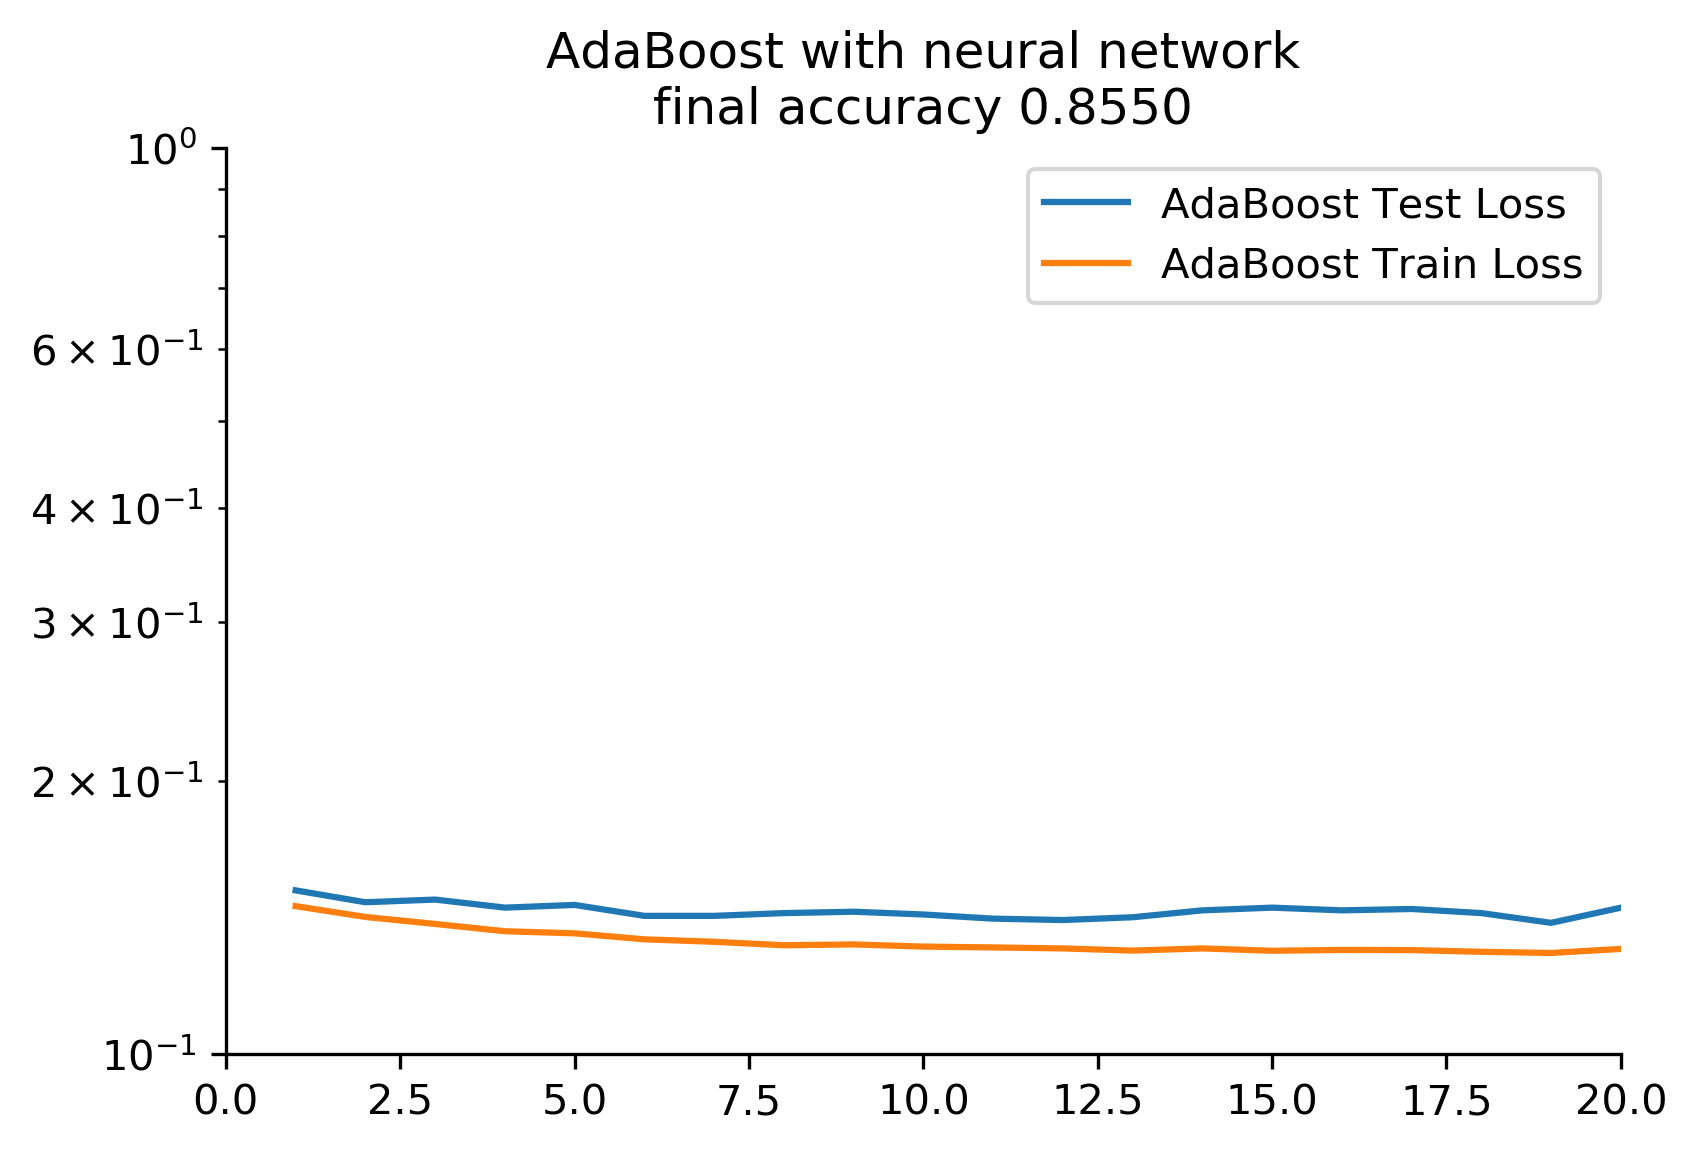

In [31]:
plot_ada_hist(ada_nn, 'AdaBoost with neural network\nfinal accuracy %.4f'
             %ada_nn.score(x_test, y_test))